In [2]:
import pandas as pd

#
# Data comes from: https://www.microsoft.com/en-us/research/project/mslr/
#
# Reading: https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/MSR-TR-2010-82.pdf
#

fixed_columns = ['Relevance', 'QueryID']
feature_columns = ['Feature{}'.format(x) for x in range(1, 137)]

converters = {
    col : lambda value: float(value.split(':')[1])
    for col in feature_columns
}

df = pd.read_csv('../../Downloads/MSLR-WEB10K/Fold1/train.txt', delimiter=' ', header=None,
                 names=fixed_columns + feature_columns, converters=converters, nrows=100000)

In [3]:
df.sort_values(by=['QueryID'], inplace=True)

In [4]:
df.head()

,Relevance,QueryID,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,...,Feature127,Feature128,Feature129,Feature130,Feature131,Feature132,Feature133,Feature134,Feature135,Feature136
0,2,qid:1,3.0,3.0,0.0,0.0,3.0,1.0,1.0,0.0,...,62.0,11089534.0,2.0,116.0,64034.0,13.0,3.0,0.0,0.0,0.0
63,0,qid:1,3.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,...,16.0,11934.0,1.0,47719.0,29019.0,6.0,4.0,0.0,0.0,0.0
62,0,qid:1,3.0,0.0,3.0,0.0,3.0,1.0,0.0,1.0,...,44.0,5.0,30.0,23836.0,63634.0,2.0,4.0,0.0,0.0,0.0
61,0,qid:1,3.0,0.0,3.0,0.0,3.0,1.0,0.0,1.0,...,59.0,5.0,8.0,213.0,48469.0,1.0,13.0,0.0,0.0,0.0
60,0,qid:1,3.0,0.0,3.0,0.0,3.0,1.0,0.0,1.0,...,44.0,0.0,30.0,23871.0,63634.0,3.0,4.0,0.0,0.0,0.0


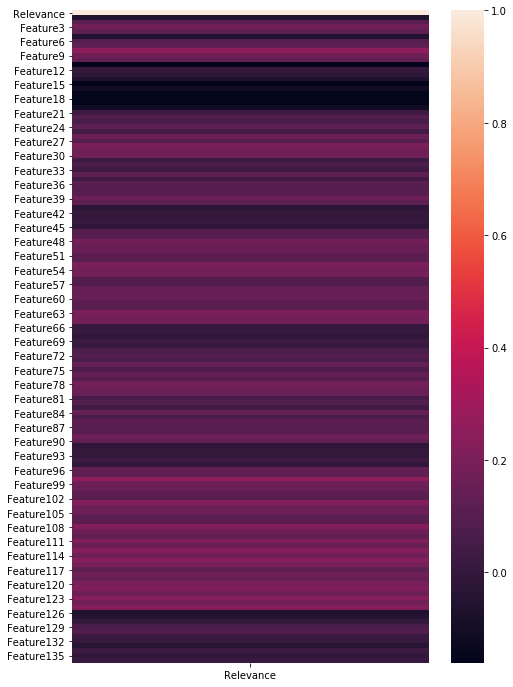

In [19]:
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

plt.figure(figsize = (8,12))
_ = sns.heatmap(df.corr()[['Relevance']])

In [51]:
df.corr()[['Relevance']].sort_values(by='Relevance', ascending=False).head(n=10)

,Relevance
Relevance,1.000000
Feature98,0.257401
Feature8,0.254079
Feature123,0.237891
Feature115,0.230539
Feature113,0.228610
Feature108,0.222890
Feature125,0.222312
Feature103,0.220817
Feature111,0.218642


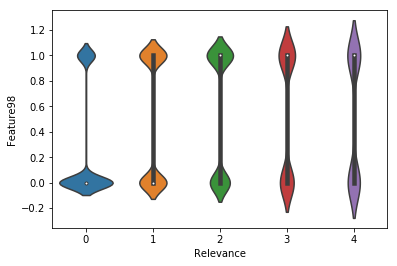

In [43]:
_ = sns.violinplot(x='Relevance', y='Feature98', data=df)

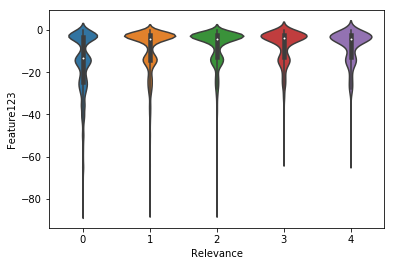

In [44]:
_ = sns.violinplot(x='Relevance', y='Feature123', data=df)

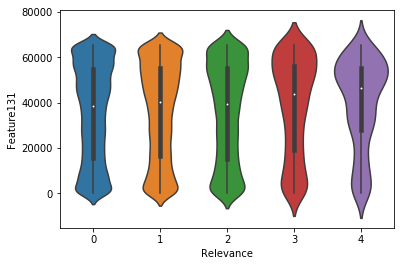

In [56]:
_ = sns.violinplot(x='Relevance', y='Feature131', data=df)

In [58]:
from sklearn.model_selection import train_test_split

y = df['Relevance']
groups = df['QueryID']
X = df.drop(['Relevance', 'QueryID'], axis=1)

Xt, Xv, yt, yv, gt, gv = train_test_split(X, y, groups, shuffle=False)

gt = pd.Series(gt).groupby(gt).size()
gv = pd.Series(gv).groupby(gv).size()

In [63]:
from lightgbm import LGBMRanker

model = LGBMRanker(n_estimators=100, num_leaves=9, colsample_bytree=0.5)

model.fit(Xt, yt, group=gt, eval_set=[(Xv, yv), (Xt, yt)], eval_group=[gv, gt], eval_at=[10], verbose=25)

[25]	training's ndcg@10: 0.468154	valid_0's ndcg@10: 0.427558
[50]	training's ndcg@10: 0.487396	valid_0's ndcg@10: 0.437053
[75]	training's ndcg@10: 0.505437	valid_0's ndcg@10: 0.440364
[100]	training's ndcg@10: 0.518794	valid_0's ndcg@10: 0.441902


LGBMRanker(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
      learning_rate=0.1, max_depth=-1, min_child_samples=20,
      min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
      n_jobs=-1, num_leaves=9, objective=None, random_state=None,
      reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
      subsample_for_bin=200000, subsample_freq=1)

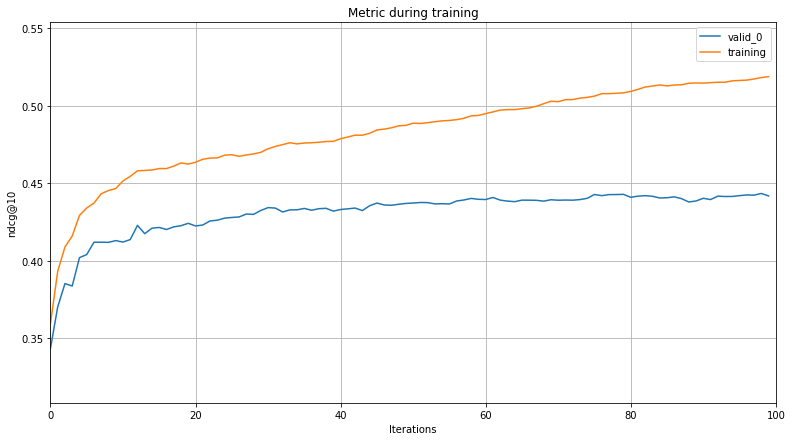

In [64]:
from lightgbm import plot_metric

plot_metric(model, metric='ndcg@10', figsize=(13,7))

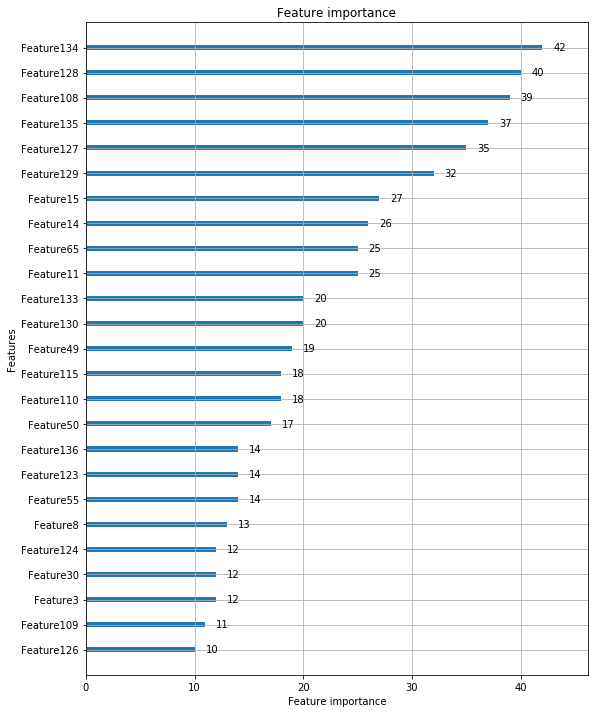

In [65]:
from lightgbm import plot_importance

plot_importance(model, max_num_features=25, figsize=(9,12))